# CNN for Image Classification of MNIST digits  
Tutorial: https://mlscrapbook.notion.site/Simple-Image-Classification-CNN-75f93ce38538498eb42287bf853a98fe

## Setup Datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')

Install packages

In [2]:
!source myvenv/bin/activate

In [3]:
# !pip3 install torch

In [4]:
# !pip3 install torchvision

In [5]:
# !pip3 uninstall urllib3 -y
# !pip3 install 'urllib3<2.0' 
# https://stackoverflow.com/questions/76187256/importerror-urllib3-v2-0-only-supports-openssl-1-1-1-currently-the-ssl-modu

In [6]:
# !pip3 install matplotlib

In [7]:
import torch
from   torch.utils.data import Subset
import torchvision
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

Load dataset

In [8]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
# https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision

Examine dataset

In [9]:
print("Length of train dataset: ",len(mnist_trainset))
print("Length of test dataset: " ,len(mnist_testset))

Length of train dataset:  60000
Length of test dataset:  10000


The first dimension contains the images. The second dimension contains the label.

In [10]:
np.shape(mnist_trainset)

(60000, 2)

Sample  250  is of digit  3


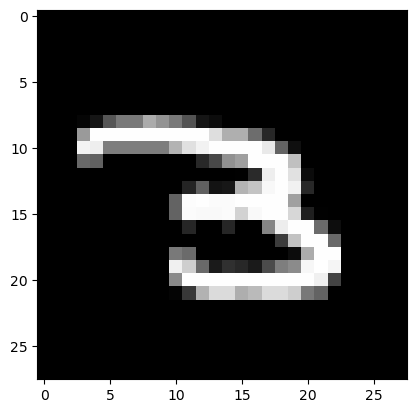

In [11]:
# pick a sample to plot
sample = 250 # NOTE: change this value to inspect different samples (within range 0 to 59,999)
image  = mnist_trainset[sample][0][0]
label  = mnist_trainset[sample][1]
print("Sample ",sample," is of digit ",label)

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()
# https://github.com/MrDataScience/tutorials/blob/master/Data/MNIST/How%20To%20Plot%20MNIST%20Digits%20Using%20Matplotlib.ipynb

In [12]:
("The images are of shape: ",np.shape(mnist_trainset[0][0]))

('The images are of shape: ', torch.Size([1, 28, 28]))

In [13]:
train_counts = np.unique(mnist_trainset.targets, return_counts=True)
test_counts  = np.unique(mnist_testset.targets, return_counts=True)

train_class_counts = {}
test_class_counts  = {}

for i in range(0, 10):
    train_class_counts[i] = train_counts[1][i]
    test_class_counts[i]  = test_counts[1][i]

print("Train: ", train_class_counts)
print("Test:  ", test_class_counts)

Train:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test:   {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Create subsets of the dataset, to speed up computation on a CPU only device

In [14]:
small_train_subset_indices = list(range(10000))  # Adjust the range as needed
small_test_subset_indices  = list(range(2500))  # Adjust the range as needed
small_mnist_trainset       = Subset(mnist_trainset, small_train_subset_indices)
small_mnist_testset        = Subset(mnist_testset,  small_test_subset_indices)

med_train_subset_indices = list(range(30000))  # Adjust the range as needed
med_test_subset_indices  = list(range(5000))  # Adjust the range as needed
med_mnist_trainset       = Subset(mnist_trainset, med_train_subset_indices)
med_mnist_testset        = Subset(mnist_testset,  med_test_subset_indices)

In [15]:
small_train_loader = torch.utils.data.DataLoader(small_mnist_trainset, batch_size=16)
small_test_loader  = torch.utils.data.DataLoader(small_mnist_testset,  batch_size=250)

med_train_loader   = torch.utils.data.DataLoader(med_mnist_trainset,   batch_size=32)
med_test_loader    = torch.utils.data.DataLoader(med_mnist_testset,    batch_size=500)

full_train_loader  = torch.utils.data.DataLoader(mnist_trainset,       batch_size=64)
full_test_loader   = torch.utils.data.DataLoader(mnist_testset,        batch_size=1000)

In [16]:
print("----------------------------------")
print(" Size  | Training set | Test set")
print("- - - - - - - - - - - - - - - - - ")
print(" Small | ",len(small_train_loader.dataset),"      | ",len(small_test_loader.dataset))
print(" Med   | ",len(med_train_loader.dataset),"      | ",len(med_test_loader.dataset))
print(" Full  | ",len(full_train_loader.dataset),"      | ",len(full_test_loader.dataset))
print("----------------------------------")

----------------------------------
 Size  | Training set | Test set
- - - - - - - - - - - - - - - - - 
 Small |  10000       |  2500
 Med   |  30000       |  5000
 Full  |  60000       |  10000
----------------------------------


Select dataset size

In [17]:
option = ['small', 'med', 'full']
dataset_size = option[2] # NOTE: change this to the dataset size of your choice

if dataset_size == 'small':
    train_loader = small_train_loader
    test_loader  = small_test_loader
elif dataset_size == 'med':
    train_loader = med_train_loader
    test_loader  = med_test_loader
else:
    train_loader = full_train_loader
    test_loader  = full_test_loader

## Create neural network; a CNN

Install packages

In [18]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torchvision import transforms

A simple Convolutional Neural Network architecture

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [20]:
print(Net())

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [21]:
# !pip install torchviz

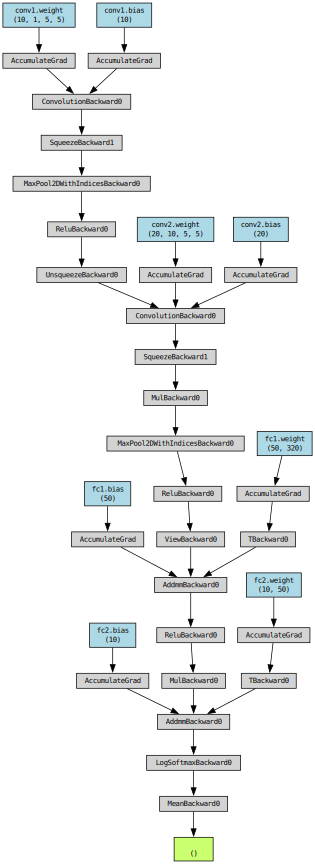

In [22]:
from torchviz import make_dot

model = Net()
sample = 250
image  = mnist_trainset[sample][0]
y = model(image)
make_dot(y.mean(), params=dict(model.named_parameters()))

## Initialise Model

Setup hyperparameters

In [23]:
n_epochs         = 10
learning_rate    = 0.01
momentum         = 0.5
log_interval     = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Initialise network and optimiser

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Model Training Loop

In [25]:
train_losses  = []
train_counter = []
test_losses   = []
test_counter  = [i*len(train_loader.dataset) for i in range(n_epochs)]

In [26]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

## Model Testing Loop

In [27]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Train the model, and evaluate after each epoch

In [28]:
print("Training on dataset size: ",dataset_size)

Training on dataset size:  full


In [29]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.342954
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.273560
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.302422
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.252791
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.222759
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.230528
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.175945
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.144530
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.046716
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.158230
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.846135
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.868668
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.762915
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.757905
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.487701
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.535187
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.393228
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.295238
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.445839
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.337970
Train Epoch: 1 [12800/60000 (

## Evaluate the model's final performance

Text(0, 0.5, 'negative log likelihood loss')

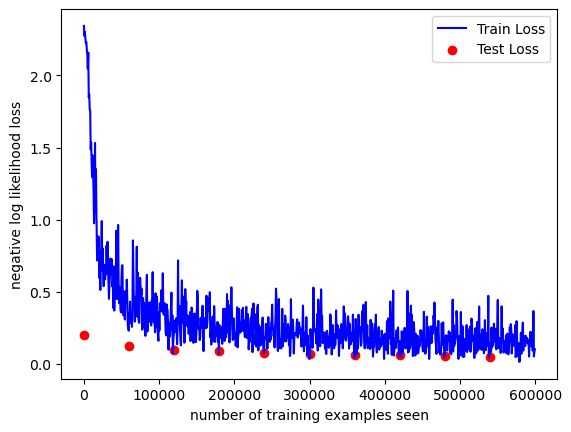

In [30]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [31]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

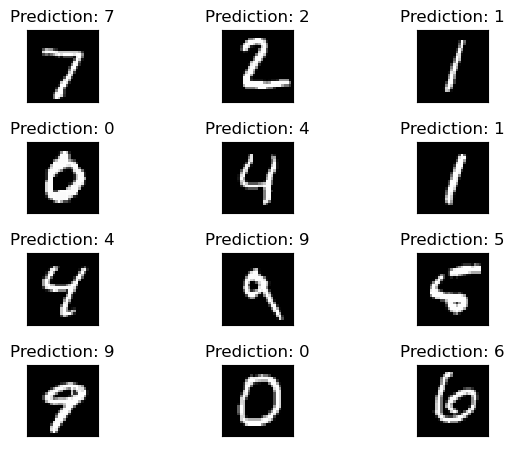

In [32]:
output = network(example_data)
fig = plt.figure()
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [33]:
from PIL import Image

In [34]:
# https://sketch.io/sketchpad/

In [35]:
handdrawn_image = Image.open('handdrawn.jpg')

In [36]:
print("Image shape is ",np.shape(handdrawn_image)," but needs to be ",np.shape(example_data[0]))

Image shape is  (832, 954, 4)  but needs to be  torch.Size([1, 28, 28])


In [37]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),  # This converts to float tensor
    transforms.Lambda(lambda x: 1 - x),  # Invert the grayscale
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

In [38]:
# load and normalise an image
def prepare_image(image):
    normalized_image = transform(image)
    return normalized_image

In [39]:
img_tensor = prepare_image(handdrawn_image) 

In [40]:
print(np.shape(img_tensor) == np.shape(example_data[0]))

True


In [41]:
def plot_mnist_image(tensor_image):
    # Ensure tensor is 2D (remove channel dimension if present)
    plt_image = tensor_image.squeeze().numpy()
    plt.imshow(plt_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [42]:
def evaluate_image(filepath):
    # load your image
    PIL_image = Image.open(filepath)

    # reshape, greyscale, to tensor and normalise the same as mnist
    image = prepare_image(PIL_image)

    # make prediction
    output = network(image)
    pred_class = output.data.max(1, keepdim=True)[1][0].item()
    print("Prediction: ",pred_class)
    return image, pred_class, output

In [43]:
def probabilities_for_classes(output):
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 
    probabilities = torch.softmax(output, dim=1)
    for cls, prob in zip(class_names, probabilities[0]):
        print(f"{cls}: {prob.item():.4f}")

Prediction:  5


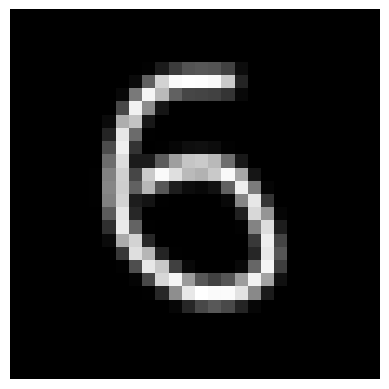

0: 0.0041
1: 0.0000
2: 0.0000
3: 0.0025
4: 0.0000
5: 0.9732
6: 0.0179
7: 0.0000
8: 0.0016
9: 0.0006


In [44]:
image_out, pred_class, output = evaluate_image('handdrawn.jpg')
plot_mnist_image(image_out[0])
probabilities_for_classes(output)

Prediction:  6


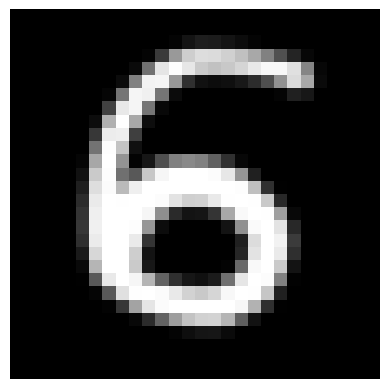

0: 0.0001
1: 0.0000
2: 0.0000
3: 0.0000
4: 0.0000
5: 0.4480
6: 0.5506
7: 0.0000
8: 0.0013
9: 0.0000


In [45]:
image_out2, pred_class, output = evaluate_image('handdrawn2.jpg')
plot_mnist_image(image_out2[0])
probabilities_for_classes(output)

Prediction:  1


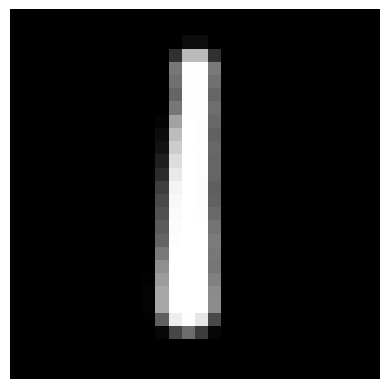

0: 0.0000
1: 0.9998
2: 0.0000
3: 0.0000
4: 0.0001
5: 0.0000
6: 0.0000
7: 0.0000
8: 0.0001
9: 0.0000


In [46]:
image_out3, pred_class, output = evaluate_image('handdrawn3.jpg')
plot_mnist_image(image_out3[0])
probabilities_for_classes(output)